In [4]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.special import lambertw, factorial
from scipy.optimize import linprog

### Relating to $p_n(t)$

###### System of ODEs

We have the following system of ODEs:

$$\begin{equation}\label{eq 2.4}
    \mathcal{L}[\mathbf{p}]_n = \begin{cases}
        -(\mu - p_1) p_0 &\quad n = 0, \\
        2 p_2 + (\mu - p_1)p_0 - (\mu - p_1)p_1 &\quad n= 1, \\
        (n+1)p_{n+1} + (\mu - p_1)p_{n-1} - (n+\mu - p_1)p_n &\quad n \geq 2.
    \end{cases}
\end{equation}$$

Since we only have a finite system, we need to cap it at $p_N$, so we give
$$\frac{dp_N}{dt} = (\mu - p_1)p_{n-1} - (n+\mu - p_1)p_N.$$

By which, we set $p_{N+1} = 0$.

In [5]:
def system_of_odes(t, y):
    """
    Defines a system of ordinary differential equations (ODEs) to be solved.

    This function represents a system of ODEs that depends on a parameter `mu` 
    and an input vector `y`. The function calculates the derivatives of the 
    elements in `y` with respect to time `t`.

    Parameters:
    -----------
    t : float
        The independent variable, typically representing time. This parameter 
        is included for compatibility with ODE solvers but is not used directly 
        in the calculations.
    y : list or numpy array of floats
        The dependent variables, a vector representing the state of the system.
        The length of `y` is N+1, where N is the maximum number of states, 
        assumed to be at least 2.

    Returns:
    --------
    dyn_dt : list of floats
        A list containing the time derivatives of the elements of `y`, with 
        each entry corresponding to the derivative of the corresponding element 
        in `y`.
    
    Notes:
    ------
    - The parameter `mu` is a global variable and must be defined before 
      calling this function.
    - The system of ODEs is defined for the first element (`y[0]`), the second 
      element (`y[1]`), and the last element (`y[N]`) separately as edge cases.
    - For elements between the second and the last (`y[2]` to `y[N-1]`), the 
      derivatives are computed using a general formula.
    """

    # Global mu, since mu cannot be added inside the call
    global mu
    
    # Let's say N = 5 is max, so y has dim N+1, N>=2
    N = len(y) - 1
    
    # Define the edge cases separately
    dy0_dt = -(mu - y[1]) * y[0]
    dy1_dt = 2 * y[2] + (mu - y[1]) * y[0] - (mu - y[1]) * y[1]
    dyN_dt = (mu - y[1]) * y[N-1] - (N + mu - y[1]) * y[N]

    # Define the general cases
    dyn_dt = [(n + 1) * y[n + 1] + (mu - y[1]) * y[n - 1] - (n + mu - y[1]) * y[n] for n in range(2, N)]

    # Insert/append the edge cases
    dyn_dt.insert(0, dy0_dt)
    dyn_dt.insert(1, dy1_dt)
    dyn_dt.append(dyN_dt)
    
    return dyn_dt

###### Random Starting State

In [6]:
def random_starting_state(N, mu):
    """
    Generates a random starting state for a system, satisfying certain constraints.

    This function creates a random starting state vector `x` of length `N+1` by solving a 
    linear programming problem with specific equality constraints. The random values are 
    generated and then optimized to satisfy these constraints.

    Parameters:
    -----------
    N : int
        The number of states minus one, defining the length of the state vector `x` as `N+1`.
    mu : float
        A parameter that defines the sum of the product of indices and state variables, 
        used as a constraint in the linear programming problem.

    Returns:
    --------
    x : numpy array of floats
        The optimized starting state vector of length `N+1`, which satisfies the specified 
        constraints if the linear programming problem is successful.
        Returns `None` if no solution exists.

    Notes:
    ------
    - The linear programming problem is solved using the `linprog` function from the `scipy.optimize` module.
    - The constraints are defined as follows:
        - The sum of all elements in the state vector `x` must be equal to 1.
        - The weighted sum of the elements in `x` by their indices must be equal to `mu`.
    - If the linear programming problem does not find a feasible solution, the function 
      prints a message and returns `None`.
    """

    # Generate random weights for the linear programming objective function
    weights = np.random.uniform(0, 1, N+1) * np.arange(1, N+2)**2
    
    # Define the equality constraints matrix and right-hand side
    equality_lhs = np.vstack([np.ones(N+1).reshape(1, -1), np.arange(N+1).reshape(1, -1)])
    equality_rhs = np.array([[1], [mu]])
    
    # Solve the linear programming problem
    sol = linprog(c=weights, A_eq=equality_lhs, b_eq=equality_rhs)
    
    # Check if a feasible solution was found
    if sol.success:
        return sol.x
    else:
        print("No solution exists")
        return None

###### Solve ODEs Numerically

µ = 3, ν = 2.8214393721220787
Total initial probability: 1.0000000000025613
Initial mean: 3.000000000013318


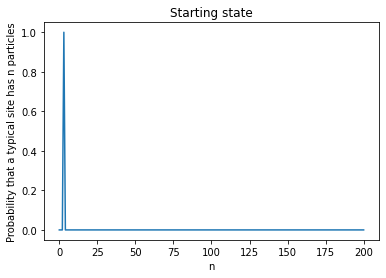

In [7]:
# Initial conditions (nu<1 whenever mu<1.58) (nu>1 whenever mu > 2.32)
mu = 3
nu = (mu + lambertw(-mu * np.exp(-mu))).real
print(f"µ = {mu}, ν = {nu.real}")

N = 200  # Number of p_n we want to investigate (p_N is max)

# Initial state vector y0, generated by random_starting_state function
y0 = np.append(random_starting_state(10, mu), np.zeros(190))

# Optionally, we can implement the starting state proposed in the paper
#y0 = [1-mu/N] + [0 for i in range(N-1)] + [mu/N] # Following the paper

# Time span for the simulation
t_start, t_end = 0, 15
t_span = (t_start, t_end)

# Time points at which to store the computed solution
no_intervals = 10_001
t_eval = np.linspace(t_start, t_end, no_intervals)

# Print initial conditions statistics
print(f"Total initial probability: {sum(y0)}")
print(f"Initial mean: {sum([y0[i] * i for i in range(len(y0))])}")

# Solve the system using the RK45 method
sol = solve_ivp(system_of_odes, t_span, y0, method='RK45', t_eval=t_eval)

# Plot the initial state vector y0
fig, ax = plt.subplots()

ax.set_title("Starting state")
ax.set_ylabel("Probability that a typical site has n particles")
ax.set_xlabel("n")
ax.plot(y0)

###### Plot asymptotic distribution of $p_n(t)$

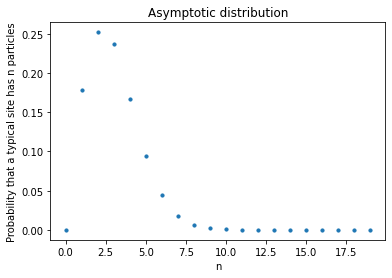

In [8]:
# Extract the asymptotic distribution from the solution
y_asymp = [sol.y[i][-1] for i in range(0, N+1)]

# Create a plot for the asymptotic distribution
fig, ax = plt.subplots()

# Set the title of the plot
ax.set_title("Asymptotic distribution")

# Label the y-axis to describe the probability
ax.set_ylabel("Probability that a typical site has n particles")

# Label the x-axis to represent the index `n`
ax.set_xlabel("n")

# Scatter plot of the first 20 data points of the asymptotic distribution
ax.scatter(range(0, N+1)[:20], y_asymp[:20], s=10)

###### Plot specific $p_n(t)$

Text(0.5, 1.0, 'Solution of the system of ODEs using RK45')

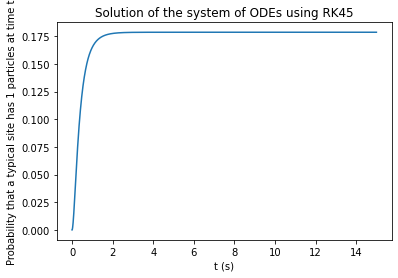

In [9]:
# Plot the results
n = 1  # Index of the state variable p_n to be plotted

fig, ax = plt.subplots()

# Plot the probability of having `n` particles at each time point
ax.plot(sol.t, sol.y[n])

# Set y-axis to logarithmic scale for better visualization of data across orders of magnitude
ax.set_yscale("linear")

# Label the y-axis with the probability description
ax.set_ylabel(f"Probability that a typical site has {n} particles at time t")

# Label the x-axis with time in seconds
ax.set_xlabel("t (s)")

# Set the title of the plot
ax.set_title('Solution of the system of ODEs using RK45')

###### Plot decay to asymptotic Poisson distribution

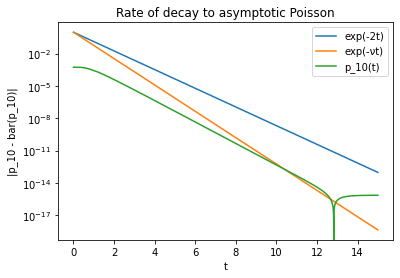

In [10]:
n = 10# Index of p_n to be plotted
p = sol.y[n]  # Extract the solution for p_n from the ODE solution

# Create a plot to compare the decay of p_n to the asymptotic Poisson distribution
fig, ax = plt.subplots()

# Set the y-axis to a logarithmic scale for better visualization of decay rates
ax.set_yscale('log')

# Optional: Plot the exponential decay functions for comparison
# ax.plot(t_eval[:-1], np.exp(-t_eval[:-1]), label="exp(-t)")
ax.plot(t_eval[:-1], np.exp(-2*t_eval[:-1]), label="exp(-2t)")

# Plot the exponential decay of the asymptotic Poisson distribution
ax.plot(t_eval[:-1], np.exp(-nu * t_eval[:-1]), label="exp(-νt)")

# Plot the absolute difference between the solution p_n(t) and the asymptotic Poisson distribution
ax.plot(t_eval, np.abs(p - (nu**n / factorial(n) * 1 / (np.exp(nu) - 1))), label=f"p_{n}(t)")

# Set the title of the plot
ax.set_title("Rate of decay to asymptotic Poisson")

# Label the y-axis to indicate the difference between p_n(t) and the asymptotic value
ax.set_ylabel(f"|p_{n} - bar(p_{n})|")

# Label the x-axis to indicate time
ax.set_xlabel("t")

# Display the legend to differentiate between plotted curves
ax.legend()

### Relating to $v(t)$

###### Computing auxiliarty function $v$

Iteration scheme through integral equations

Recall that

$$v(t) = \exp\left(\int_0^t e^{-t+s} (\mu - p_1(s)) ds\right).$$

In [11]:
def simpsons_rule(f_values):
    """
    Compute the integral of a function using Simpson's rule for multiple intervals.
    
    Parameters:
    f_values (list or array): List of function values at equally spaced points.
    
    Returns:
    float: Approximate value of the integral.
    """
    global interval_length
    
    n = len(f_values) - 1  # Number of intervals
    if n % 2 != 0:
        raise ValueError("Number of intervals must be even (number of points must be odd).")
    
    h = interval_length  # Width of each interval
    
    integral = f_values[0] + f_values[-1]
    for i in range(1, n, 2):
        integral += 4 * f_values[i]
    for i in range(2, n, 2):
        integral += 2 * f_values[i]
    
    integral *= h / 3
    
    return integral

In [12]:
# Simpson's method for numerical integration

p1 = sol.y[1]  # Extract the solution for the second state variable p_1

# Calculate the length of each interval for Simpson's method
interval_length = (t_end - t_start) / (no_intervals - 1)

# Initialize list to store results of Simpson's integration
v = [1]  # Initial value (or starting point for the integration)

# Iterate over every other time point (even indices) for Simpson's method
for i in range(2, no_intervals, 2):
    t = t_eval[i]  # Current time point

    # Calculate the values to be integrated using Simpson's rule
    values_for_each_t = np.exp(-t + t_eval[:i+1]) * (mu - p1[:i+1])
    
    # Append the result of Simpson's rule to the list
    v.append(np.exp(simpsons_rule(values_for_each_t)))

# Shorten the time list to match the length of the result list
t_list = t_eval[range(0, no_intervals, 2)][:-1]

# Print asymptotic error
print(f"Error: {v[-1] - np.exp(nu)}")

Error: -1.3861124426028937e-05


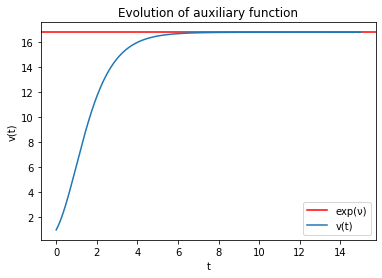

In [13]:
# Create a plot to visualize the evolution of the auxiliary function
fig, ax = plt.subplots()

# Set the title of the plot
ax.set_title("Evolution of auxiliary function")

# Label the y-axis to indicate the value of the auxiliary function
ax.set_ylabel("v(t)")

# Label the x-axis to indicate time
ax.set_xlabel("t")

# Add a horizontal line at y = e^ν for reference
ax.axhline(np.exp(nu), c="red", label="exp(ν)")

# Plot the evolution of the auxiliary function v(t)
ax.plot(t_list, v[:-1], label="v(t)")

# Display the legend to identify the plotted curves
ax.legend()

###### Plot decay rate of auxiliary function $v(t)$

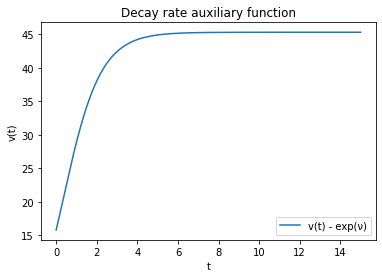

In [16]:
# Create a plot to visualize the evolution of the auxiliary function and its deviation
fig, ax = plt.subplots()

# Set the title of the plot
ax.set_title("Decay rate auxiliary function")

# Label the y-axis to indicate the value of the auxiliary function
ax.set_ylabel("v(t)")

# Label the x-axis to indicate time
ax.set_xlabel("t")

# Set the y-axis to a logarithmic scale for better visualization of variations
ax.set_yscale("linear")

# Plot the absolute difference between the auxiliary function v(t) and the exponential reference value e^ν
ax.plot(t_list, (np.abs(v[:-1] - np.exp(nu)))*np.exp(t_list), label="v(t) - exp(ν)")

# Plot the exponential decay function exp(-t) for comparison
#ax.plot(t_list, np.exp(-nu * t_list), label="exp(-νt)")

# Plot the exponential decay function exp(-t) for comparison
#ax.plot(t_list, np.exp(-t_list), label="exp(-t)")

# Display the legend to differentiate between the plotted curves
ax.legend()

###### Plot derivative of auxiliary function

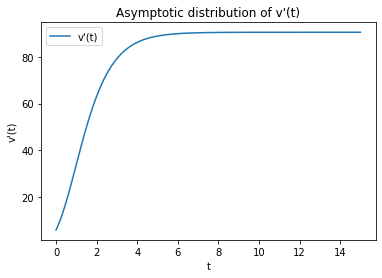

In [17]:
# Compute derivative numerically
dv_dt = np.abs(np.array(v)[1:] - np.array(v)[:-1])/interval_length

# Create a plot to visualize the asymptotic distribution of the derivative of the auxiliary function v'(t)
fig, ax = plt.subplots()

# Set the y-axis to a logarithmic scale for better visualization of variations
ax.set_yscale('linear')

# Plot the exponential decay function exp(-t) for reference
#ax.plot(t_list, np.exp(-t_list)*np.exp(2.4), label="exp(-t)")

# Plot the exponential decay function exp(-νt) where ν is the computed parameter
#ax.plot(t_list, np.exp(-nu.real * t_list), label="exp(-νt)")

# Plot the derivative of the auxiliary function v(t)
ax.plot(t_list, dv_dt*np.exp(t_list), label="v'(t)")

# Set the title of the plot
ax.set_title("Asymptotic distribution of v'(t)")

# Label the y-axis to represent the value of the derivative v'(t)
ax.set_ylabel("v'(t)")

# Label the x-axis to represent time
ax.set_xlabel("t")

# Display the legend to identify the different curves
ax.legend()


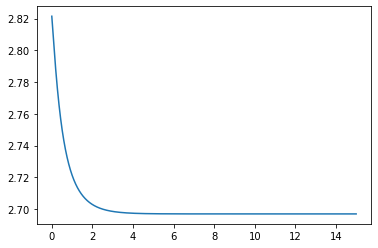

In [19]:
plt.plot(t_list, np.abs(np.log(v[:-1])-nu)*np.exp(t_list))

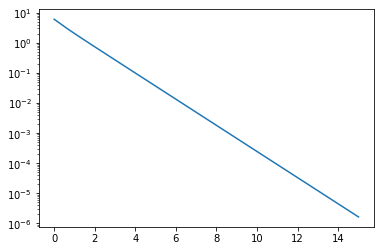

In [45]:
# Create a plot to visualize the asymptotic distribution of the derivative of the auxiliary function v'(t)
fig, ax = plt.subplots()

# Set the y-axis to a logarithmic scale for better visualization of variations
ax.set_yscale('log')
ax.plot(t_list, (dv_dt/v[:-1]))

###### Corollary 4.10 $|p_1(t) - \mu + \nu|$

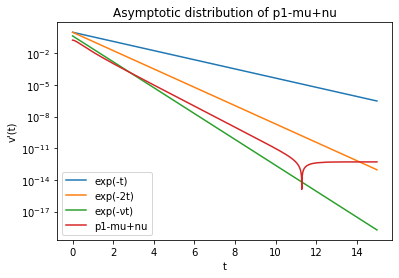

In [43]:
# Create a plot to visualize the asymptotic distribution p1-mu+nu
fig, ax = plt.subplots()

# Set the y-axis to a logarithmic scale for better visualization of variations
ax.set_yscale('log')

# Plot the exponential decay function exp(-t) for reference
ax.plot(t_list, np.exp(-t_list), label="exp(-t)")

# Plot the exponential decay function exp(-2t) for reference
ax.plot(t_list, np.exp(-2*t_list), label="exp(-2t)")

# Plot the exponential decay function exp(-νt) where ν is the computed parameter
ax.plot(t_list, np.exp(-nu.real * t_list) *np.exp(-0.8), label="exp(-νt)")

# Plot p1+mu-nu
ax.plot(t_list, np.abs(p1[range(0, no_intervals, 2)][:-1] - mu + nu), label="p1-mu+nu")

# Set the title of the plot
ax.set_title("Asymptotic distribution of p1-mu+nu")

# Label the y-axis to represent the value of the derivative v'(t)
ax.set_ylabel("v'(t)")

# Label the x-axis to represent time
ax.set_xlabel("t")

# Display the legend to identify the different curves
ax.legend()


### Relating to $||\mathbf{p}(t) - \overline{\mathbf{p}}||_{\ell^1}$

In [300]:
# Calculate the absolute difference between each value in the solution matrix and the final value in that column
p_bar = np.abs(sol.y[:65] - sol.y[:65, -1].reshape(-1, 1))

# Compute the L1 norm of the differences for each time point
# The L1 norm is the sum of absolute differences for each time point
p_l1_norm = np.sum(p_bar, axis=0)

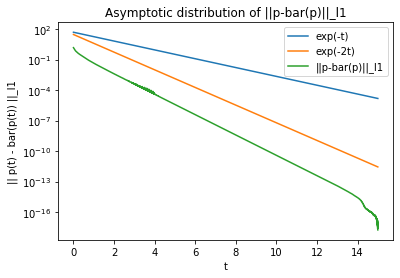

In [301]:
# Create a plot to visualize the asymptotic distribution of the L1 norm difference ||p(t) - bar(p(t))||_l1
fig, ax = plt.subplots()

# Set the y-axis to a logarithmic scale for better visualization of the data, especially for exponential decay
ax.set_yscale('log')

# Plot reference exponential decay functions for comparison
ax.plot(t_eval, 50 * np.exp(-t_eval), label="exp(-t)")
ax.plot(t_eval[:-1], 30 * np.exp(-2 * t_eval[:-1]), label="exp(-2t)")

# Optionally, another exponential decay function can be plotted (commented out in this example)
# ax.plot(t_eval[:-1], 40 * np.exp(-nu.real * t_eval[:-1]), label="exp(-νt)")

# Set the title of the plot
ax.set_title("Asymptotic distribution of ||p-bar(p)||_l1")

# Label the y-axis to represent the L1 norm difference
ax.set_ylabel("|| p(t) - bar(p(t)) ||_l1")

# Label the x-axis to represent time
ax.set_xlabel("t")

# Plot the L1 norm of the difference between the solution p(t) and its final state
ax.plot(t_eval[:-1], p_l1_norm[:-1], label="||p-bar(p)||_l1")

# Display the legend to identify the different curves in the plot
ax.legend()
